# DMS - Data Analysis

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from abag_affinity.utils.config import read_config, get_data_paths

In [2]:
config = read_config("../../config.yaml")

summary_path, _ = get_data_paths(config, "DMS")

dms_df = pd.read_csv(summary_path)

In [3]:
complexes = dms_df.groupby(["publication", "antibody", "antigen"])

In [4]:
dms_df

,publication,antibody,mutation_code,antigen,-log(Kd),E,NLL,-log(IC50)
0,phillips21_bindin,cr6261,SD167R;ND196K;KD211D;SD214G;AD216V;LD241V,h1newcal99,9.444671,NaN,NaN,NaN
1,phillips21_bindin,cr6261,SD167R;ND196K;QD199P;KD211D;SD212F;AD216V;LD241V,h1newcal99,9.429218,NaN,NaN,NaN
2,phillips21_bindin,cr6261,SD167R;ND196K;KD211D;SD214G;LD241V,h1newcal99,9.099022,NaN,NaN,NaN
3,phillips21_bindin,cr6261,SD167R;KD211D;SD214G;AD216V,h1newcal99,9.322949,NaN,NaN,NaN
4,phillips21_bindin,cr6261,SD167R;QD199P;KD211D;AD216V,h1newcal99,8.612018,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
421519,mason21_optim_therap_antib_by_predic_dms_L,trastuzumab,QD89W;PD95T,her2,NaN,0.334380,0.647040,NaN
421520,mason21_optim_therap_antib_by_predic_dms_L,trastuzumab,QD89Y;YD92D;PD95R,her2,NaN,0.478243,0.647040,NaN
421521,mason21_optim_therap_antib_by_predic_dms_L,trastuzumab,QD89Y;TD93L,her2,NaN,0.372375,0.647040,NaN
421522,mason21_optim_therap_antib_by_predic_dms_L,trastuzumab,QD89Y,her2,NaN,0.548717,0.022802,NaN


### Number of mutations for complex

<AxesSubplot:ylabel='publication,antibody,antigen'>

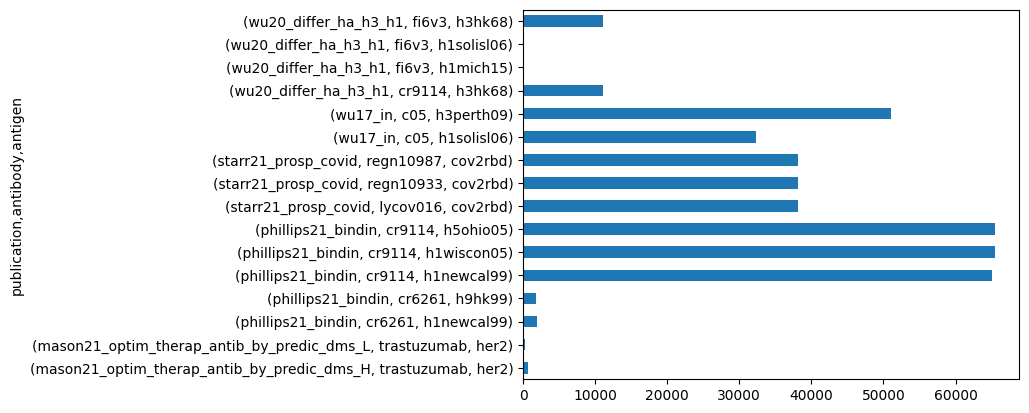

In [5]:
complexes["mutation_code"].count().plot(kind="barh")

## Distribution of affinity values

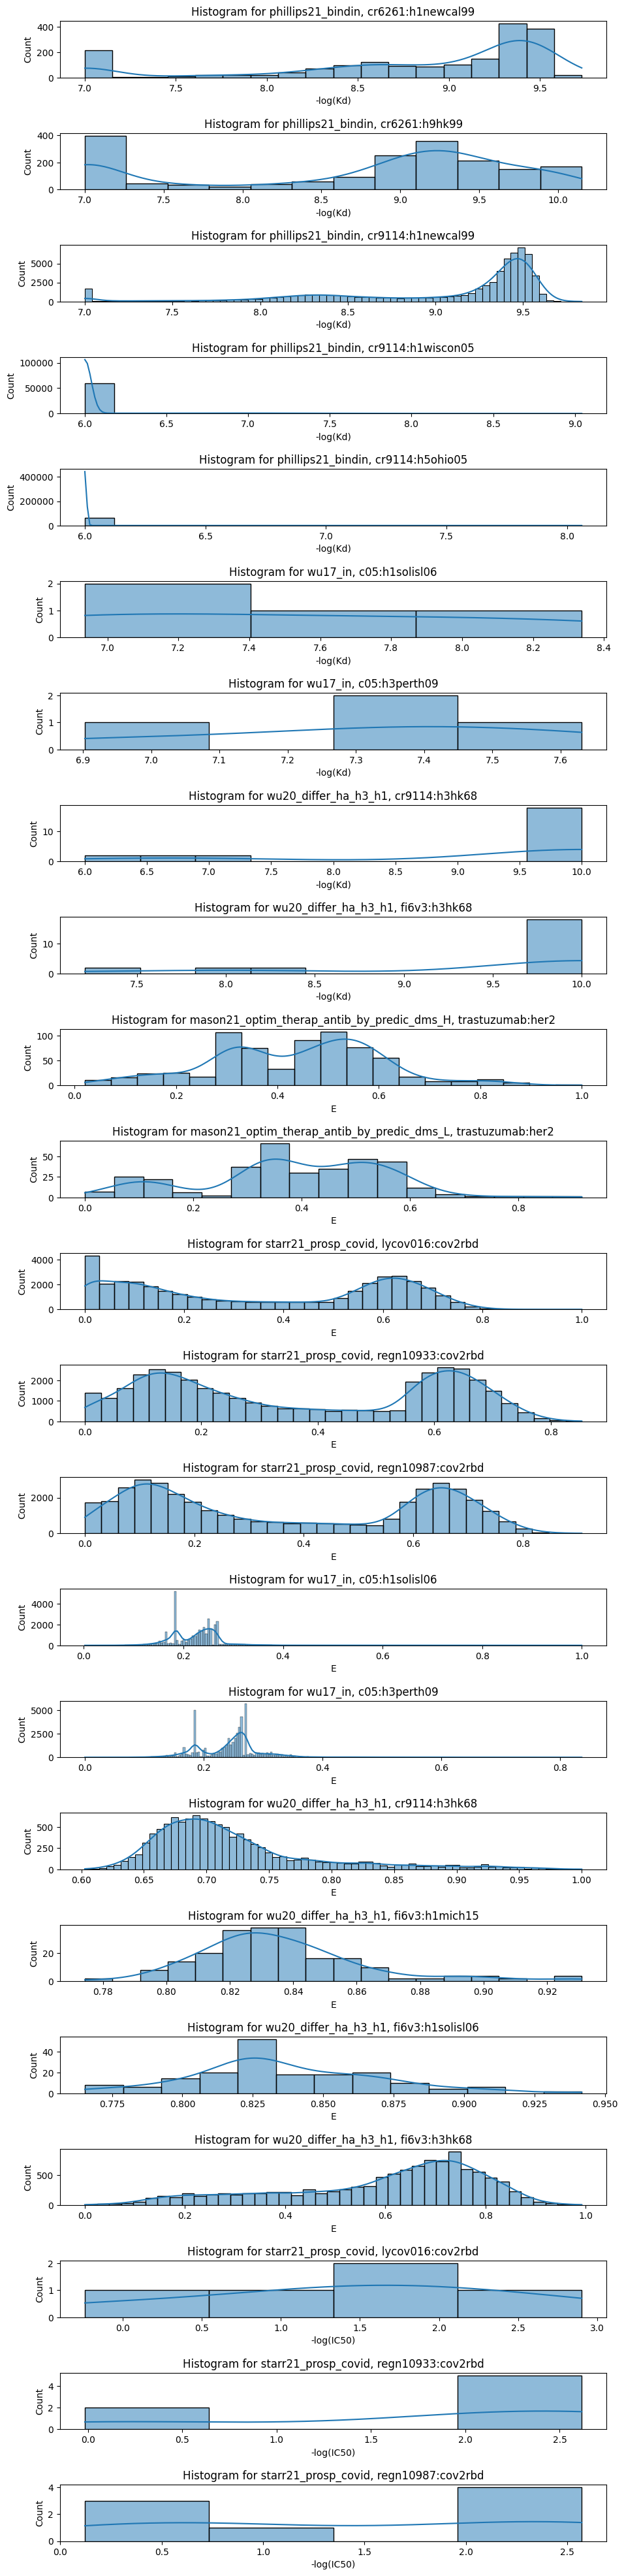

In [6]:
fig, axs = plt.subplots(figsize=(10,40), nrows=23)
fig.tight_layout(pad=4.0)

i = 0

for col in ["-log(Kd)","E", "-log(IC50)"]:

    for group, idx in complexes.groups.items():
        group_df = dms_df.iloc[idx]

        if any(group_df[col].notnull()):
            sns.histplot(group_df, x=col, kde=True, ax=axs[i]).set_title(f"Histogram for {group[0]}, {group[1]}:{group[2]}")
            i += 1

## Error analysis of generation process

In [8]:
generation_log_path = os.path.join(config["DATA"]["path"], 
                                   config["DATA"]["DMS"]["folder_path"], 
                                   config["DATA"]["DMS"]["mutated_pdb_path"],
                                  "{}/{}_{}.logs")


'/home/fabian/Desktop/Uni/Masterthesis/ag_binding_affinity/data/DMS/mutated/a/b_C.logs'

In [21]:
all_logs = []

for group, idx in complexes.groups.items():
    publication, antibody, antigen = group
    group_log_path = generation_log_path.format(publication, antibody, antigen)
    if os.path.exists(group_log_path):
        group_logs = pd.read_csv(group_log_path)
        group_logs["publication"] = publication
        group_logs["antibody"] = antibody
        group_logs["antigen"] = antigen
        all_logs.append(group_logs)
    else:
        print(f"No logs available for {publication}, {antibody}:{antigen}")
        
all_logs = pd.concat(all_logs)
all_logs.reset_index(inplace=True)

No logs available for mason21_optim_therap_antib_by_predic_dms_H, trastuzumab:her2
No logs available for mason21_optim_therap_antib_by_predic_dms_L, trastuzumab:her2


In [41]:
failed_jobs = (all_logs[" status"] != " processed").sum()
print(f"In total {failed_jobs} jobs fail of {len(all_logs)} jobs")

In total 107 jobs fail of 420488 jobs


#### Check if all files exist

In [34]:
generation_files_path = os.path.join(config["DATA"]["path"], 
                                   config["DATA"]["DMS"]["folder_path"], 
                                   config["DATA"]["DMS"]["mutated_pdb_path"],
                                  "all_generated_files.txt")

with open(generation_files_path) as f:
    lines = f.readlines()

lines = [ line.strip().split("/") for line in lines if line.strip()[-4:] == ".pdb"]
lines = [ {"publication": line[1], 
           "antibody": line[2].split("_")[0], 
           "antigen": line[2].split("_")[1],
           "mutation_code": line[3].split(".")[0]
          } for line in lines]

generated_files = pd.DataFrame(lines)

In [42]:
all_files = all_logs.merge(generated_files, how='left', indicator=True, on=["publication", "antibody", "antigen", "mutation_code"])
all_files[all_files["_merge"] != "both"]

,index,mutation_code,status,error_msg,publication,antibody,antigen,_merge
1374,1374,NaN,error,unsupported operand type(s) for +: 'float' an...,phillips21_bindin,cr6261,h1newcal99,left_only
3234,1347,NaN,error,unsupported operand type(s) for +: 'float' an...,phillips21_bindin,cr6261,h9hk99,left_only
66885,63156,NaN,error,unsupported operand type(s) for +: 'float' an...,phillips21_bindin,cr9114,h1newcal99,left_only
131978,63155,NaN,error,unsupported operand type(s) for +: 'float' an...,phillips21_bindin,cr9114,h1wiscon05,left_only
197512,63154,NaN,error,unsupported operand type(s) for +: 'float' an...,phillips21_bindin,cr9114,h5ohio05,left_only
...,...,...,...,...,...,...,...,...
417791,8495,NaN,error,unsupported operand type(s) for +: 'float' an...,wu20_differ_ha_h3_h1,fi6v3,h3hk68,left_only
417792,8496,NaN,error,unsupported operand type(s) for +: 'float' an...,wu20_differ_ha_h3_h1,fi6v3,h3hk68,left_only
417793,8497,NaN,error,unsupported operand type(s) for +: 'float' an...,wu20_differ_ha_h3_h1,fi6v3,h3hk68,left_only
417794,8498,NaN,error,unsupported operand type(s) for +: 'float' an...,wu20_differ_ha_h3_h1,fi6v3,h3hk68,left_only


### Get redudancy with AbAg Dataset